In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm import tqdm
from scipy.optimize import approx_fprime
from scipy.linalg import block_diag, solve
from utils import get_form_initial_conditions
from tudatpy.astro.time_conversion import DateTime
from dynamics import SatelliteDynamics, Propagator

In [2]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 395  # Duration [min]

# Set simulation start (0 TDB seconds since J2000) and end epochs
simulation_start_epoch = DateTime(2000, 1, 1).epoch()
simulation_end_epoch = (T - 1) * dt

T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # State dimension
n_p = 3  
n_y_1 = 3 
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 2 # Window size [min]

In [3]:
# Initial state vector and get the true state vectors
X_initial = get_form_initial_conditions(formation)
propagator = Propagator(simulation_start_epoch, simulation_end_epoch, dt, X_initial)
X_true = propagator.run().T.reshape(24, 1, T)

Warning, you are using the deprecated (as of tudatpy v0.8) version of the cannonball radiation pressure model, the interface you are using will be dropped from v0.9 onwards. To learn how to convert your code to the new interfaces, and be able to use the powerful new radiation pressure framework, see https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/propagation_setup/translational/radiation_pressure_acceleration.html#backwards-compatibility
Warning, you are using the deprecated (as of tudatpy v0.8) version of the cannonball radiation pressure model, the interface you are using will be dropped from v0.9 onwards. To learn how to convert your code to the new interfaces, and be able to use the powerful new radiation pressure framework, see https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/propagation_setup/translational/radiation_pressure_acceleration.html#backwards-compatibility
Warning, you are using the deprecated (as of tudatpy v0.8) version of the 

In [15]:
# Estimate process noise
X_our_model = np.zeros((24, 1, T))
X_our_model[:, :, 0] = X_initial
for t in range(T - 1):
    X_our_model[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

# Compute the difference between the ground truth and the model after initial conditions
diff = X_true[:, :, 1:] - X_our_model[:, :, 1:]
diff_flattened = diff.T.reshape(-1, 24)

# Calculate the general covariance matrix of the flattened differences
Q = np.cov(diff_flattened, rowvar=False)

# Create a zero matrix of the same shape
Q_modified = np.zeros_like(Q)

# Fill only the required block diagonals
Q_modified[:6, :6] = np.diag(np.diag(Q[:6, :6]))
Q_modified[6:12, 6:12] = np.diag(np.diag(Q[6:12, 6:12]))
Q_modified[12:18, 12:18] = np.diag(np.diag(Q[12:18, 12:18]))
Q_modified[18:, 18:] = np.diag(np.diag(Q[18:, 18:]))
Q = Q_modified
pd.DataFrame(Q[:6, :6]), pd.DataFrame(Q[6:12, 6:12]), pd.DataFrame(Q[12:18, 12:18]), pd.DataFrame(Q[18:, 18:])

(         0         1         2        3         4         5
 0  0.03608  0.000000  0.000000  0.00000  0.000000  0.000000
 1  0.00000  0.014237  0.000000  0.00000  0.000000  0.000000
 2  0.00000  0.000000  0.038345  0.00000  0.000000  0.000000
 3  0.00000  0.000000  0.000000  0.00004  0.000000  0.000000
 4  0.00000  0.000000  0.000000  0.00000  0.000016  0.000000
 5  0.00000  0.000000  0.000000  0.00000  0.000000  0.000043,
           0         1         2        3         4         5
 0  0.036056  0.000000  0.000000  0.00000  0.000000  0.000000
 1  0.000000  0.014228  0.000000  0.00000  0.000000  0.000000
 2  0.000000  0.000000  0.038309  0.00000  0.000000  0.000000
 3  0.000000  0.000000  0.000000  0.00004  0.000000  0.000000
 4  0.000000  0.000000  0.000000  0.00000  0.000016  0.000000
 5  0.000000  0.000000  0.000000  0.00000  0.000000  0.000043,
           0        1         2        3         4         5
 0  0.036116  0.00000  0.000000  0.00000  0.000000  0.000000
 1  0.000000  0

In [5]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [6]:
def h_function_chief(x_vec):
    """
    Computes the measurement vector based on the current state vector.
    The measurement vector includes position components.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).
    """
    return x_vec[0:3]

def h_function_deputy(x_vec):
    """
    Computes the measurement vector based on the current state vector.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).

    Returns:
    y (np.array): The measurement vector of the satellite (range [km]).
    """
    r_chief = x_vec[:3]
    r_deputy1 = x_vec[6:9]
    r_deputy2 = x_vec[12:15]
    r_deputy3 = x_vec[18:21]

    range_deputy1_chief = np.linalg.norm(r_deputy1 - r_chief)
    range_deputy1_deputy2 = np.linalg.norm(r_deputy1 - r_deputy2)
    range_deputy1_deputy3 = np.linalg.norm(r_deputy1 - r_deputy3)
    range_deputy2_chief = np.linalg.norm(r_deputy2 - r_chief)
    range_deputy2_deputy3 = np.linalg.norm(r_deputy2 - r_deputy3)
    range_deputy3_chief = np.linalg.norm(r_deputy3 - r_chief)

    return np.array(
        [
            [range_deputy1_chief],
            [range_deputy1_deputy2],
            [range_deputy1_deputy3],
            [range_deputy2_chief],
            [range_deputy2_deputy3],
            [range_deputy3_chief],
        ]
    )

def h(x_vec):
    return np.concatenate([h_function_chief(x_vec), h_function_deputy(x_vec)])

In [7]:
# Simulation setup
np.random.seed(42)
X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

In [16]:
def cost_function(X, Y):
    cost_fun = 0
    
    # Iterate over all sliding window time steps
    for k in range(W):    
        # Get x(k)
        x_1_k = X[n_x * (4 * k): n_x * (4 * k + 1), :]
        x_2_k = X[n_x * (4 * k + 1): n_x * (4 * k + 2), :]
        x_3_k = X[n_x * (4 * k + 2): n_x * (4 * k + 3), :]
        x_4_k = X[n_x * (4 * k + 3): n_x * (4 * k + 4), :]
            
        # Process noise terms
        if k < W - 1:
            X_k = X[n_x * (4 * k):n_x * (4 * k + 4), :]
            X_k_next = X[n_x * (4 * (k + 1)):n_x * (4 * (k + 1) + 4), :]
            residual = X_k_next - SatelliteDynamics().x_new(dt, X_k)
            cost_fun += 1 / 2 * residual.T @ np.linalg.inv(Q) @ residual
        
        # Absolute residual term: observed data y for each state
        y_1_k = Y[:n_y_1, :, k]
        y_rel_k = Y[n_y_1:, :, k]

        # Update the cost function with the residuals for self-measurements
        residual = y_1_k - P @ x_1_k
        cost_fun += 1 / 2 * residual.T @ np.linalg.inv(R_chief) @ residual

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (x_2_k, x_1_k, y_21_k),  # (2, 1)
            (x_2_k, x_3_k, y_23_k),  # (2, 3)
            (x_2_k, x_4_k, y_24_k),  # (2, 4)
            (x_3_k, x_1_k, y_31_k),  # (3, 1)
            (x_3_k, x_4_k, y_34_k),  # (3, 4)
            (x_4_k, x_1_k, y_41_k),  # (4, 1)
        ]

        # Iterate over each pair and update the cost function with the residuals for pairwise measurements
        for x_i_k, x_j_k, y_ij_k in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)
            cost_fun += (y_ij_k - d_ij_k) ** 2 / (2 * r_deputy_pos**2)

    return cost_fun

def gradient(X, Y):
    grad = np.zeros_like(X)
    
    # Iterate over all sliding window time steps
    for k in range(W):
        # Get x(k)
        x_1_k = X[n_x * (4 * k): n_x * (4 * k + 1), :]
        x_2_k = X[n_x * (4 * k + 1): n_x * (4 * k + 2), :]
        x_3_k = X[n_x * (4 * k + 2): n_x * (4 * k + 3), :]
        x_4_k = X[n_x * (4 * k + 3): n_x * (4 * k + 4), :]
            
        # Process noise terms
        if k < W - 1:
            X_k = X[n_x * (4 * k):n_x * (4 * k + 4), :]
            X_k_next = X[n_x * (4 * (k + 1)):n_x * (4 * (k + 1) + 4), :]
            residual = X_k_next - SatelliteDynamics().x_new(dt, X_k)
            grad[n_x * (4 * k):n_x * (4 * k + 4), :] -= SatelliteDynamics().Phi(dt, X_k).T @ np.linalg.inv(Q) @ residual
            grad[n_x * (4 * (k + 1)):n_x * (4 * (k + 1) + 4), :] += np.linalg.inv(Q) @ residual
        
        # Absolute residual term: observed data y for each state
        y_1_k = Y[:n_y_1, :, k]
        y_rel_k = Y[n_y_1:, :, k]

        # Compute gradients for the absolute residual terms
        grad[n_x * (4 * k):n_x * (4 * k + 1), :] -= P.T @ np.linalg.inv(R_chief) @ (y_1_k - P @ x_1_k)

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k),  # (4, 1)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Update the gradient of f(x) with respect to x_i(k) and x_j(k)
            grad[n_x * (4 * k + (i - 1)):n_x * (4 * k + i), :] -= (y_ij_k - d_ij_k) / r_deputy_pos**2 * P.T @ d_ij_k_vec / d_ij_k
            grad[n_x * (4 * k + (j - 1)):n_x * (4 * k + j), :] += (y_ij_k - d_ij_k) / r_deputy_pos**2 * P.T @ d_ij_k_vec / d_ij_k

    return grad

def hessian(X, Y):
    hess = np.zeros((X.shape[0], X.shape[0]))
    
    # Iterate over all sliding window time steps
    for k in range(W):
        # Get x(k)
        x_1_k = X[n_x * (4 * k): n_x * (4 * k + 1), :]
        x_2_k = X[n_x * (4 * k + 1): n_x * (4 * k + 2), :]
        x_3_k = X[n_x * (4 * k + 2): n_x * (4 * k + 3), :]
        x_4_k = X[n_x * (4 * k + 3): n_x * (4 * k + 4), :]
            
        # Process noise terms
        if k < W - 1:
            X_k = X[n_x * (4 * k):n_x * (4 * k + 4), :]
            X_k_next = X[n_x * (4 * (k + 1)):n_x * (4 * (k + 1) + 4), :]
            Phi_k = SatelliteDynamics().Phi(dt, X_k)
            hess[n_x * (4 * k):n_x * (4 * k + 4), n_x * (4 * k):n_x * (4 * k + 4)] += Phi_k.T @ np.linalg.inv(Q) @ Phi_k
            hess[n_x * (4 * k):n_x * (4 * k + 4), n_x * (4 * (k + 1)):n_x * (4 * (k + 1) + 4)] -= np.linalg.inv(Q) @ Phi_k
            hess[n_x * (4 * (k + 1)):n_x * (4 * (k + 1) + 4), n_x * (4 * k):n_x * (4 * k + 4)] -= Phi_k.T @ np.linalg.inv(Q)
            hess[n_x * (4 * (k + 1)):n_x * (4 * (k + 1) + 4), n_x * (4 * (k + 1)):n_x * (4 * (k + 1) + 4)] += np.linalg.inv(Q)
        
        # Absolute residual term: observed data y for each state
        y_1_k = Y[:n_y_1, :, k]
        y_rel_k = Y[n_y_1:, :, k]

        # Compute gradients for the absolute residual terms
        hess[n_x * (4 * k):n_x * (4 * k + 1), n_x * (4 * k):n_x * (4 * k + 1)] += P.T @ np.linalg.inv(R_chief) @ P

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k),  # (4, 1)
        ]
        
        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Second derivative (Hessian) of relative measurement residual
            hessian_rel = -1 / (r_deputy_pos ** 2) * ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P)

            # Update the Hessian for x_i(k) and x_j(k)
            idx_i = n_x * (4 * k + (i - 1))
            idx_j = n_x * (4 * k + (j - 1))

            hess[idx_i:idx_i + n_x, idx_i:idx_i + n_x] += hessian_rel
            hess[idx_j:idx_j + n_x, idx_j:idx_j + n_x] += hessian_rel
            hess[idx_i:idx_i + n_x, idx_j:idx_j + n_x] -= hessian_rel
            hess[idx_j:idx_j + n_x, idx_i:idx_i + n_x] -= hessian_rel

    return hess

# def numerical_gradient(f, x_0, y, epsilon=1e-6):
#     grad = np.zeros_like(x_0)
#     for i in range(x_0.size):
#         # Create perturbed versions of x_0
#         x_0_plus = x_0.copy()
#         x_0_minus = x_0.copy()
        
#         # Add and subtract epsilon to the i-th component
#         x_0_plus[i] += epsilon
#         x_0_minus[i] -= epsilon
        
#         # Compute the function value for perturbed inputs
#         f_plus = f(x_0_plus, y)
#         f_minus = f(x_0_minus, y)
        
#         # Central difference approximation
#         grad[i] = (f_plus - f_minus) / (2 * epsilon)
    
#     return grad

# n = 0
# W = 2
# numerical_grad = numerical_gradient(cost_function, X_true[:, :, n:n + W].reshape(4 * n_x, W).T.reshape(W * 4 * n_x, 1), Y[:, :, n:n + W]).flatten()
# analytical_grad = gradient(X_true[:, :, n:n + W].reshape(4 * n_x, W).T.reshape(W * 4 * n_x, 1), Y[:, :, n:n + W]).flatten()
# print("Numerical Gradient:", numerical_grad)
# print("Analytical Gradient:", analytical_grad)
# print("Gradient Difference:", numerical_grad - analytical_grad)
# print(np.sum(np.abs(numerical_grad - analytical_grad)))

In [9]:
def force_positive_definiteness(P):
    """
    Ensures the matrix P is positive definite by adjusting its eigenvalues if necessary.

    Parameters:
        P (numpy.ndarray): The input square matrix.

    Returns:
        numpy.ndarray: A modified positive definite matrix.
    """

    # Ensure P is a square matrix
    P = np.atleast_2d(P)

    P = 0.5 * (P + P.T)  # Ensure symmetry

    # Compute eigenvalues and eigenvectors
    d, V = np.linalg.eigh(P)  # FIX: Correctly unpack eigenvalues and eigenvectors

    # Ensure d is writable
    d = np.copy(d)

    # Find the smallest positive eigenvalue
    dmin = np.max([np.min(d[d > np.finfo(float).eps], initial=np.finfo(float).eps), np.finfo(float).eps * 1e6])

    # Adjust non-positive eigenvalues
    d[d < np.finfo(float).eps] = dmin  

    # Construct the diagonal matrix
    D = np.diag(d)  # Ensure it's a 2D matrix

    # Reconstruct P using V and D (V is orthogonal, so V.T is stable)
    P = V @ D @ V.T

    return P


In [17]:
class NewtonSolver:
    def __init__(self, tolerance=1e0, max_iter=20):
        self.grad_tol = tolerance
        self.max_iter = max_iter
        self.i = None
        
        # Storage for results
        self.cost_function_values = []
        self.grad_norm_values = []

    def solve(self, finite_horizon_start_timestamp, X_init, Y, X_true):
        X = X_init

        prev_cost_function_value = None
        prev_grad_norm_value = None
        prev_global_error = None

        for iteration in range(self.max_iter):
            # Compute the cost function, gradient of the Lagrangian and Hessian of the Lagrangian
            cost_fun = cost_function(X, Y)
            grad = gradient(X, Y)
            hess = hessian(X, Y)

            # Convergence tracking
            cost_function_value = cost_fun[0][0]
            grad_norm_value = np.linalg.norm(grad)

            # Store the norms
            self.cost_function_values.append(cost_function_value)
            self.grad_norm_values.append(grad_norm_value)

            if prev_cost_function_value is not None:
                cost_function_change = (cost_function_value - prev_cost_function_value) / abs(prev_cost_function_value) * 100
                grad_norm_change = (grad_norm_value - prev_grad_norm_value) / abs(prev_grad_norm_value) * 100
                global_error_change = (np.linalg.norm(X - X_true) - prev_global_error) / abs(prev_global_error) * 100
            prev_cost_function_value = cost_function_value
            prev_grad_norm_value = grad_norm_value
            prev_global_error = np.linalg.norm(X - X_true)

            # Check convergence and print metrics
            print()
            if grad_norm_value < self.grad_tol or iteration + 1 == self.max_iter:
                print(f"STOP on Iteration {iteration}\nCost function = {cost_function_value} ({cost_function_change:.2f}%)\nGradient norm = {grad_norm_value} ({grad_norm_change:.2f}%)\nGlobal relative error = {np.linalg.norm(X - X_true)} ({global_error_change:.2f}%)")
                print(f"Final position relative errors for finite-horizon #{finite_horizon_start_timestamp + 1}:")
                for k in range(W):
                    print(f"Timestamp #{finite_horizon_start_timestamp + 1 + k}: {np.linalg.norm(X[n_x * (4 * k) : n_x * (4 * k) + n_p] - X_true[n_x * (4 * k) : n_x * (4 * k) + n_p])} m, {np.linalg.norm(X[n_x * (4 * k + 1) : n_x * (4 * k + 1) + n_p] - X_true[n_x * (4 * k + 1) : n_x * (4 * k + 1) + n_p])} m, {np.linalg.norm(X[n_x * (4 * k + 2) : n_x * (4 * k + 2) + n_p] - X_true[n_x * (4 * k + 2) : n_x * (4 * k + 2) + n_p])} m, {np.linalg.norm(X[n_x * (4 * k + 3) : n_x * (4 * k + 3) + n_p] - X_true[n_x * (4 * k + 3) : n_x * (4 * k + 3) + n_p])} m")
                break
            else:
                if iteration == 0:
                    print(f"Before applying the algorithm\nCost function: {cost_function_value}\nGradient norm: {grad_norm_value}\nGlobal relative error: {np.linalg.norm(X - X_true)}")
                else:
                    print(f"Iteration {iteration}\nCost function: {cost_function_value} ({cost_function_change:.2f}%)\nGradient norm: {grad_norm_value} ({grad_norm_change:.2f}%)\nGlobal relative error: {np.linalg.norm(X - X_true)} ({global_error_change:.2f}%)")
                    
            # Print relative errors 
            print(f"Position relative errors for finite-horizon #{finite_horizon_start_timestamp + 1}:")
            for k in range(W):
                print(f"Timestamp #{finite_horizon_start_timestamp + 1 + k}: {np.linalg.norm(X[n_x * (4 * k) : n_x * (4 * k) + n_p] - X_true[n_x * (4 * k) : n_x * (4 * k) + n_p])} m, {np.linalg.norm(X[n_x * (4 * k + 1) : n_x * (4 * k + 1) + n_p] - X_true[n_x * (4 * k + 1) : n_x * (4 * k + 1) + n_p])} m, {np.linalg.norm(X[n_x * (4 * k + 2) : n_x * (4 * k + 2) + n_p] - X_true[n_x * (4 * k + 2) : n_x * (4 * k + 2) + n_p])} m, {np.linalg.norm(X[n_x * (4 * k + 3) : n_x * (4 * k + 3) + n_p] - X_true[n_x * (4 * k + 3) : n_x * (4 * k + 3) + n_p])} m")
                
            # Solve for the Newton step - this is one iteration
            # hess = force_positive_definiteness(hess)
            delta_X = solve(hess, -grad)
            # delta_X = - np.linalg.pinv(hess) @ grad
            X += delta_X
        
            # Save the current iteration
            self.i = iteration + 1

        return X

In [11]:
def give_me_the_plots(cost_function_values, grad_norm_values):
    iterations = np.arange(0, len(cost_function_values))

    # Plot 1
    plt.semilogy(iterations, cost_function_values, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$L(x^{(m)})$')
    plt.grid(True)
    plt.grid(True, which="minor", linestyle='--')
    plt.show()
    
    # Plot 2
    plt.semilogy(iterations, grad_norm_values, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$||\nabla L(x^{(m)})||_2$')
    plt.grid(True)
    plt.grid(True, which="minor", linestyle='--')
    plt.show()

Windows:   0%|          | 0/197 [00:00<?, ?it/s]


Before applying the algorithm
Cost function: 825429.6438512991
Gradient norm: 12048.971315578194
Global relative error: 559.1908556867129
Position relative errors for finite-horizon #1:
Timestamp #1: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m
Timestamp #2: 82.8742787463465 m, 181.74495804457294 m, 258.4261579002105 m, 222.5019830385067 m

Iteration 1
Cost function: 42649083.276899725 (5066.90%)
Gradient norm: 1107222.417078588 (9089.35%)
Global relative error: 804.0622272409042 (43.79%)
Position relative errors for finite-horizon #1:
Timestamp #1: 570.6168968500093 m, 184.62293529503037 m, 258.96586630801283 m, 229.65904724816463 m
Timestamp #2: 122.0546622405315 m, 182.1476539194456 m, 258.7672358662405 m, 223.89769230661315 m

Iteration 2
Cost function: 14663152688.215528 (34280.93%)
Gradient norm: 19327060.946308684 (1645.54%)
Global relative error: 11207.139223723962 (1293.81%)
Position relative errors for finite-horizon #1:
Timestamp #1: 1

/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_55546/3903575161.py:61: LinAlgWarning: Ill-conditioned matrix (rcond=8.16146e-20): result may not be accurate.
  delta_X = solve(hess, -grad)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_55546/3903575161.py:61: LinAlgWarning: Ill-conditioned matrix (rcond=6.47411e-19): result may not be accurate.
  delta_X = solve(hess, -grad)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_55546/3903575161.py:61: LinAlgWarning: Ill-conditioned matrix (rcond=3.98152e-20): result may not be accurate.
  delta_X = solve(hess, -grad)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_55546/3903575161.py:61: LinAlgWarning: Ill-conditioned matrix (rcond=2.20048e-19): result may not be accurate.
  delta_X = solve(hess, -grad)
/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_55546/3903575161.py:61: LinAlgWarning: Ill-conditioned matrix (rcond=4.34796e-21): result may not be accurate.
  delta_X = solve(hess, -g


Iteration 7
Cost function: 5.26755449835002e+25 (-86.02%)
Gradient norm: 7.803252340812586e+21 (-97.23%)
Global relative error: 2018252516707.981 (365342.06%)
Position relative errors for finite-horizon #1:
Timestamp #1: 32991477753.966515 m, 5326191.833408271 m, 5335269.894930233 m, 5323107.9538985 m
Timestamp #2: 32986904658.662575 m, 1130705648853.3535 m, 1271027184045.9058 m, 1084967841731.9646 m

Iteration 8
Cost function: 5.180776850371425e+26 (883.53%)
Gradient norm: 4.4551832794472654e+23 (5609.39%)
Global relative error: 598732919670.6182 (-70.33%)
Position relative errors for finite-horizon #1:
Timestamp #1: 351827641118.3182 m, 5467356.3260894455 m, 5474019.436737639 m, 5465267.583322987 m
Timestamp #2: 66027713572.91196 m, 268160525390.84363 m, 303186091067.56616 m, 256594733329.95978 m

Iteration 9
Cost function: 2.421451166130147e+27 (367.39%)
Gradient norm: 6.9767524008631994e+22 (-84.34%)
Global relative error: 6306449825701.636 (953.30%)
Position relative errors for f

/var/folders/tg/b7psn3916wjg1kg3phym63jh0000gn/T/ipykernel_55546/3903575161.py:61: LinAlgWarning: Ill-conditioned matrix (rcond=1.17416e-20): result may not be accurate.
  delta_X = solve(hess, -grad)



Iteration 14
Cost function: 4.007637079074201e+38 (20831.38%)
Gradient norm: 3.222598075731769e+21 (-100.00%)
Global relative error: 1.8278530456312556e+18 (1346.63%)
Position relative errors for finite-horizon #1:
Timestamp #1: 1.7843315124722985e+18 m, 32685632.84257472 m, 33751434.542181045 m, 32586734.192531258 m
Timestamp #2: 3.748428987661206e+17 m, 1.1136878460883872e+16 m, 1.1118668677248622e+16 m, 1.112882699526961e+16 m

Iteration 15
Cost function: 8.734942046365709e+40 (21695.74%)
Gradient norm: 4.767070961834386e+22 (1379.26%)
Global relative error: 2.697765256319665e+19 (1375.92%)
Position relative errors for finite-horizon #1:
Timestamp #1: 2.6329782095646163e+19 m, 2.9683721790239866e+17 m, 2.973796511170151e+17 m, 2.966541078886287e+17 m
Timestamp #2: 5.540940451610478e+18 m, 9.282853253306363e+16 m, 9.300080969265515e+16 m, 9.277533201014202e+16 m

Iteration 16
Cost function: 1.9575439176708839e+43 (22310.50%)
Gradient norm: 7.145195546625666e+23 (1398.86%)
Global rel

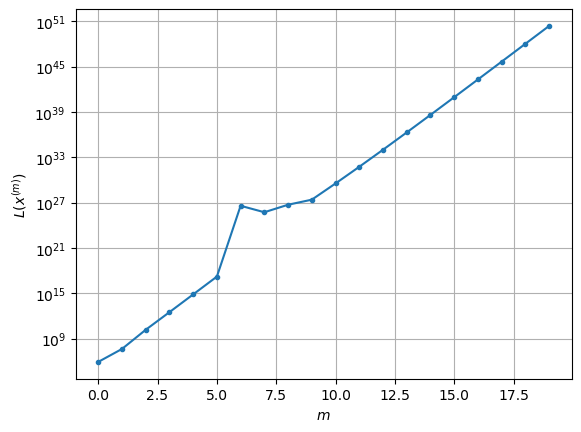

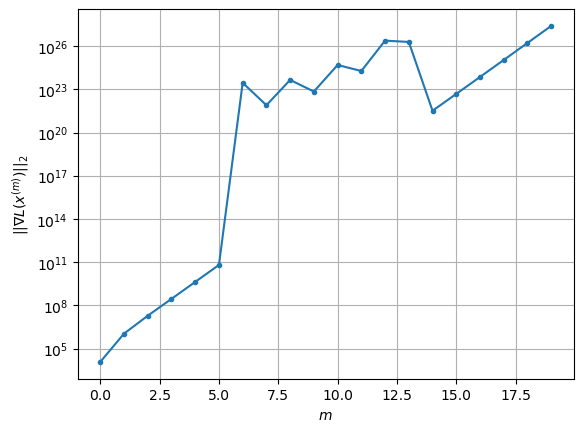

Windows:   1%|          | 1/197 [00:01<03:42,  1.13s/it]


Before applying the algorithm
Cost function: 9.384734095859105e+51
Gradient norm: 1.3906139319802735e+27
Global relative error: 1.3497960335685618e+25
Position relative errors for finite-horizon #3:
Timestamp #3: 6.150747690459866e+24 m, 6.024359488860336e+22 m, 6.03481159468528e+22 m, 6.020582733406861e+22 m
Timestamp #4: 1.2012147622841745e+25 m, 1.176531335252255e+23 m, 1.1785709722736476e+23 m, 1.1757936243934355e+23 m

Iteration 1
Cost function: 3.6935733930667623e+53 (3835.73%)
Gradient norm: 1.0618032401092514e+29 (7535.50%)
Global relative error: 5.4708873351182015e+25 (305.31%)
Position relative errors for finite-horizon #3:
Timestamp #3: 5.36179418107001e+25 m, 5.251568463642667e+23 m, 5.2607405779374224e+23 m, 5.248279461080742e+23 m
Timestamp #4: 1.0122533828741194e+25 m, 9.914118422330886e+22 m, 9.932010591783763e+22 m, 9.907952899999015e+22 m

Iteration 2
Cost function: 8.537111077374504e+55 (23013.42%)
Gradient norm: 1.494084046507477e+30 (1307.12%)
Global relative erro

/Users/joaogaspar/Desktop/Thesis/Software/SpaceSim-Toolkit/src/dynamics.py:267: RuntimeWarning: overflow encountered in scalar power
  / (2 * r**9)



Iteration 9
Cost function: 3.109979800867823e+72 (23129.42%)
Gradient norm: 2.85241853843774e+38 (1424.12%)
Global relative error: 1.6096320789699802e+35 (1424.12%)
Position relative errors for finite-horizon #3:
Timestamp #3: 1.5708262681266053e+35 m, 1.5385371028097588e+33 m, 1.5412207882580376e+33 m, 1.537572728940289e+33 m
Timestamp #4: 3.318637732425581e+34 m, 3.250343856590626e+32 m, 3.2561655089694184e+32 m, 3.248317534778111e+32 m

Iteration 10
Cost function: 7.224380791469071e+74 (23129.67%)
Gradient norm: 4.347453839861504e+39 (1424.13%)
Global relative error: 2.4532857995942867e+36 (1424.13%)
Position relative errors for finite-horizon #3:
Timestamp #3: 2.39414070792594e+36 m, 2.34492788645337e+34 m, 2.349018160647139e+34 m, 2.34345805378934e+34 m
Timestamp #4: 5.058032656425253e+35 m, 4.9539439788043644e+33 m, 4.9628169217115236e+33 m, 4.950855593786552e+33 m

Iteration 11
Cost function: 1.6782096012889746e+77 (23129.81%)
Gradient norm: 6.626098268190345e+40 (1424.13%)
Glo

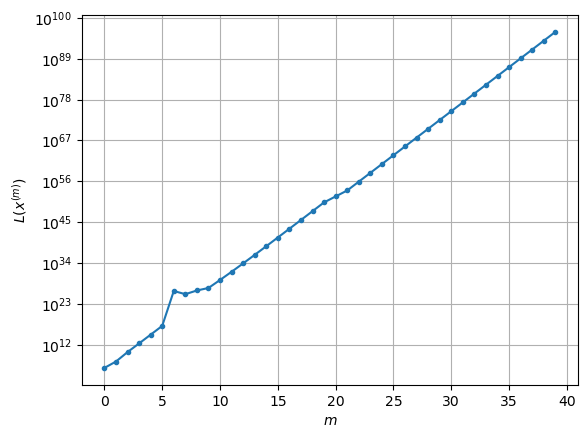

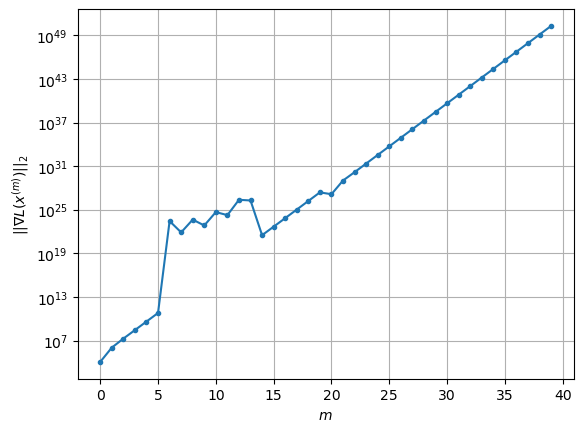

Windows:   1%|          | 2/197 [00:02<03:39,  1.12s/it]


Before applying the algorithm
Cost function: 5.6424506704636635e+97
Gradient norm: 1.0782748496161749e+50
Global relative error: 1.0466248604174958e+48
Position relative errors for finite-horizon #5:
Timestamp #5: 4.769310190007738e+47 m, 4.67130032177213e+45 m, 4.679396401932583e+45 m, 4.6683684999877164e+45 m
Timestamp #6: 9.314130384532266e+47 m, 9.122730401457643e+45 m, 9.138528755508272e+45 m, 9.117003829724906e+45 m

Iteration 1
Cost function: 2.228478958277898e+99 (3849.49%)
Gradient norm: 8.247837163024823e+51 (7549.10%)
Global relative error: 4.249583553328367e+48 (306.03%)
Position relative errors for finite-horizon #5:
Timestamp #5: 4.1647988127614706e+48 m, 4.079186443048964e+46 m, 4.0863074428478215e+46 m, 4.0766299579208183e+46 m
Timestamp #6: 7.865391405720847e+47 m, 7.703478456677845e+45 m, 7.71737865000995e+45 m, 7.698683386800181e+45 m

Iteration 2
Cost function: 5.160035787034064e+101 (23054.97%)
Gradient norm: 1.161660099042612e+53 (1308.44%)
Global relative error:

/Users/joaogaspar/Desktop/Thesis/Software/SpaceSim-Toolkit/src/dynamics.py:209: RuntimeWarning: overflow encountered in scalar multiply
  / (2 * r**5)
/Users/joaogaspar/Desktop/Thesis/Software/SpaceSim-Toolkit/src/dynamics.py:209: RuntimeWarning: overflow encountered in scalar power
  / (2 * r**5)
/Users/joaogaspar/Desktop/Thesis/Software/SpaceSim-Toolkit/src/dynamics.py:261: RuntimeWarning: overflow encountered in scalar power
  np.eye(3) / r**3 - 3 * r_vec * r_vec.T / r**5



Iteration 15
Cost function: 2.959934654630628e+132 (23129.96%)
Gradient norm: 2.7827613168459657e+68 (1424.14%)
Global relative error: 1.5703226224843177e+65 (1424.14%)
Position relative errors for finite-horizon #5:
Timestamp #5: 1.5324644242857087e+65 m, 1.5009638179123033e+63 m, 1.5035819546957813e+63 m, 1.500022991019729e+63 m
Timestamp #6: 3.237596104703351e+64 m, 3.1709699926497475e+62 m, 3.176649469098825e+62 m, 3.168993141755793e+62 m

Iteration 16
Cost function: 6.8759168494620345e+134 (23129.96%)
Gradient norm: 4.241311830945891e+69 (1424.14%)
Global relative error: 2.3933881345932134e+66 (1424.14%)
Position relative errors for finite-horizon #5:
Timestamp #5: 2.3356870220522134e+66 m, 2.2876757558021474e+64 m, 2.2916661571519037e+64 m, 2.2862418059314938e+64 m
Timestamp #6: 4.934542743416705e+65 m, 4.832995364706143e+63 m, 4.8416516696904044e+63 m, 4.829982371448755e+63 m

Iteration 17
Cost function: 1.597272846777356e+137 (23129.96%)
Gradient norm: 6.464343865365914e+70 (1

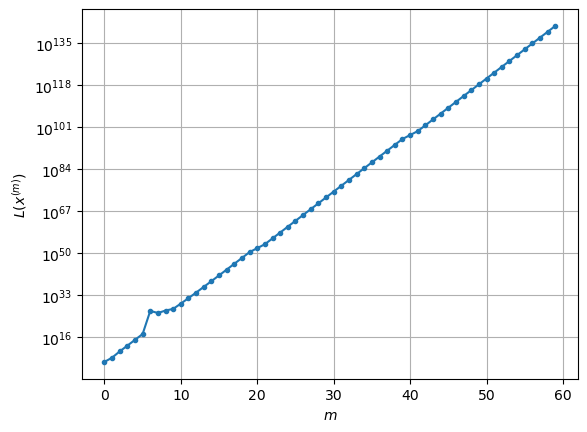

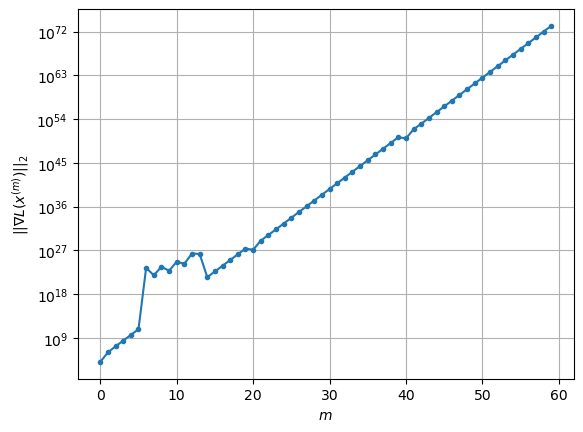

Windows:   2%|▏         | 3/197 [00:03<03:33,  1.10s/it]/Users/joaogaspar/Desktop/Thesis/Software/SpaceSim-Toolkit/src/dynamics.py:271: RuntimeWarning: overflow encountered in power
  -4 * x**4
/Users/joaogaspar/Desktop/Thesis/Software/SpaceSim-Toolkit/src/dynamics.py:282: RuntimeWarning: overflow encountered in power
  x**4
/Users/joaogaspar/Desktop/Thesis/Software/SpaceSim-Toolkit/src/dynamics.py:293: RuntimeWarning: overflow encountered in power
  3 * x**4
/Users/joaogaspar/Desktop/Thesis/Software/SpaceSim-Toolkit/src/dynamics.py:266: RuntimeWarning: invalid value encountered in multiply
  -(3 * self.earth.J_2 * self.earth.mu * self.earth.R**2)



Before applying the algorithm
Cost function: 3.417535960281284e+143
Gradient norm: 8.391742258930218e+72
Global relative error: 8.145424214928812e+70
Position relative errors for finite-horizon #7:
Timestamp #7: 3.711745839678576e+70 m, 3.635469039492321e+68 m, 3.6417698650638243e+68 m, 3.633187330612822e+68 m
Timestamp #8: 7.248780918807339e+70 m, 7.099822670768138e+68 m, 7.112117839688577e+68 m, 7.095365930034937e+68 m

Iteration 1
Cost function: 1.3497516651844008e+145 (3849.49%)
Gradient norm: 6.418931561905225e+74 (7549.10%)
Global relative error: 3.307265341511917e+71 (306.03%)
Position relative errors for finite-horizon #7:
Timestamp #7: 3.2412810793755194e+71 m, 3.1746527099206854e+69 m, 3.180194673137168e+69 m, 3.1726631091517772e+69 m
Timestamp #8: 6.121290741763263e+70 m, 5.995280962391777e+68 m, 6.006098875988707e+68 m, 5.991549168823754e+68 m

Iteration 2
Cost function: 3.125345639614212e+147 (23054.97%)
Gradient norm: 9.040693435324032e+75 (1308.44%)
Global relative erro

ValueError: array must not contain infs or NaNs

In [ ]:
# Main execution loop
def run_estimation():
    # Initialize storage for results
    X_est_mm = np.zeros_like(X_true)
    X_est_mm[:, :, :W] = X_est[:, :, :W]  # Use same initial conditions
    
    # Storage for errors
    errors_chief_mm = []
    errors_deputy1_mm = []
    errors_deputy2_mm = []
    errors_deputy3_mm = []
    
    # Initialize solver
    solver = NewtonSolver()
    
    # Initial guess
    X_init = np.zeros((4 * n_x * W, 1))
    
    # Sliding window estimation
    for t in tqdm(range(0, T - W + 1, W), desc="Windows", leave=False):
        # Get measurements for current window
        Y_window = Y[:, :, t:t + W]
        
        # Initial guess is the previous estimate propagated forward
        for k in range(W):
            X_init[4 * n_x * k: 4 * n_x * (k + 1)] = X_est_mm[:, :, t + k].reshape(4 * n_x, 1)
        
        # Solve the optimization problem
        X_sol = solver.solve(t, X_init, Y_window, X_true[:, :, t:t + W].reshape(4 * n_x, W).T.reshape(W * 4 * n_x, 1))
        
        # Store the solution
        for k in range(W):
            X_est_mm[:, :, t + k] = X_sol[4 * n_x * k: 4 * n_x * (k + 1), :]
        
        # Plot the results
        give_me_the_plots(solver.cost_function_values, solver.grad_norm_values)
        
        # Propagate solution to next timestep if not at the end
        for k in range(W):
            X_est_mm[:, :, (t + (W - 1)) + k + 1] = SatelliteDynamics().x_new(dt, X_est_mm[:, :, (t + (W - 1)) + k])
                
        # Calculate and store errors
        for k in range(W):
            error_chief = np.linalg.norm(X_est_mm[:3, :, t] - X_true[:3, :, t])
            error_deputy1 = np.linalg.norm(X_est_mm[6:9, :, t] - X_true[6:9, :, t])
            error_deputy2 = np.linalg.norm(X_est_mm[12:15, :, t] - X_true[12:15, :, t])
            error_deputy3 = np.linalg.norm(X_est_mm[18:21, :, t] - X_true[18:21, :, t])
            
            errors_chief_mm.append(error_chief)
            errors_deputy1_mm.append(error_deputy1)
            errors_deputy2_mm.append(error_deputy2)
            errors_deputy3_mm.append(error_deputy3)
    
    return X_est_mm, errors_chief_mm, errors_deputy1_mm, errors_deputy2_mm, errors_deputy3_mm

# Run the estimation
X_est_mm, errors_chief_mm, errors_deputy1_mm, errors_deputy2_mm, errors_deputy3_mm = run_estimation()

# Print RMSE for each satellite
print("RMSE after convergence:")
print(f"Chief: {np.sqrt(np.mean(np.array(errors_chief_mm[T_RMSE:])**2)):.2f} m")
print(f"Deputy 1: {np.sqrt(np.mean(np.array(errors_deputy1_mm[T_RMSE:])**2)):.2f} m")
print(f"Deputy 2: {np.sqrt(np.mean(np.array(errors_deputy2_mm[T_RMSE:])**2)):.2f} m")
print(f"Deputy 3: {np.sqrt(np.mean(np.array(errors_deputy3_mm[T_RMSE:])**2)):.2f} m")

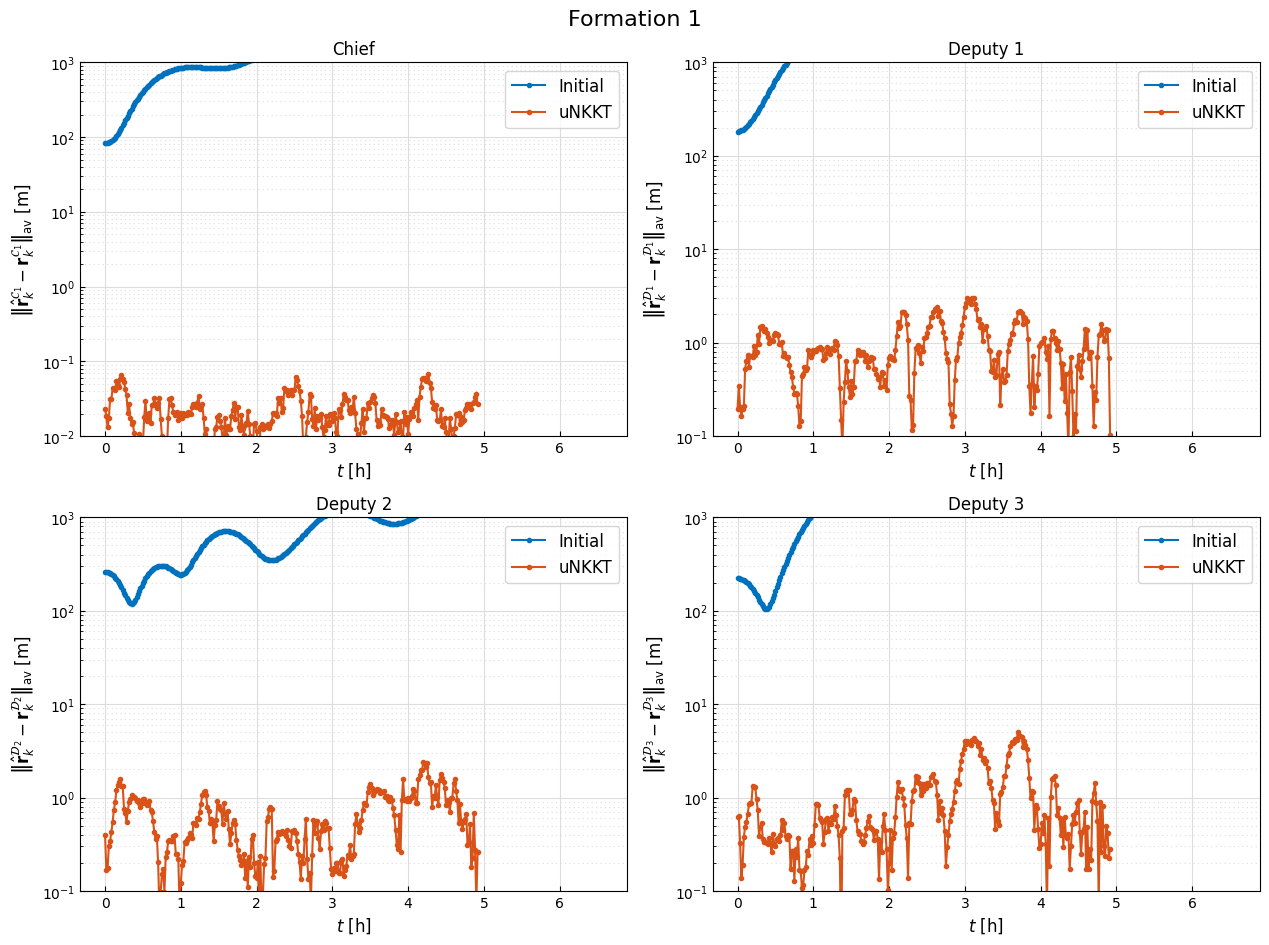

In [26]:
dev_chief = errors_chief_mm
dev_deputy1 = errors_deputy1_mm
dev_deputy2 = errors_deputy2_mm
dev_deputy3 = errors_deputy3_mm

# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, T) / dt
algorithm = "Centralized Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, dev_chief_initial, ".-", label="Initial")
axs[0, 0].plot(time[:K - W + 1], dev_chief, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, dev_deputy1_initial, ".-", label="Initial")
axs[0, 1].plot(time[:K - W + 1], dev_deputy1, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, dev_deputy2_initial, ".-", label="Initial")
axs[1, 0].plot(time[:K - W + 1], dev_deputy2, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, dev_deputy3_initial, ".-", label="Initial")
axs[1, 1].plot(time[:K - W + 1], dev_deputy3, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [29]:
import pickle
from datetime import datetime

# Fill the dictionary
data = {}
data["true"] = X_true
data[0] = X_est

# Save to pickle file
with open(
    f'newton_form{formation}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl',
    "wb",
) as file:
    pickle.dump(data, file)